# Collaboration and Competition

---

You are welcome to use this coding environment to train your agent for the project.  Follow the instructions below to get started!

### 1. Start the Environment

Run the next code cell to install a few packages.  This line will take a few minutes to run!

In [1]:
!pip -q install ./python

tensorflow 1.7.1 has requirement numpy>=1.13.3, but you'll have numpy 1.12.1 which is incompatible.
ipython 6.5.0 has requirement prompt-toolkit<2.0.0,>=1.0.15, but you'll have prompt-toolkit 3.0.8 which is incompatible.


The environment is already saved in the Workspace and can be accessed at the file path provided below. 

In [2]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
from collections import namedtuple, deque
import time
import copy

from shutil import copyfile
from IPython.display import display, clear_output
from unityagents import UnityEnvironment


env = UnityEnvironment(file_name="/data/Tennis_Linux_NoVis/Tennis")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.          0.
  0.          0.         -6.65278625 -1.5        -0.          0.
  6.83172083  6.         -0.          0.        ]


### 3. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  A few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- To structure your work, you're welcome to work directly in this Jupyter notebook, or you might like to start over with a new file!  You can see the list of files in the workspace by clicking on **_Jupyter_** in the top left corner of the notebook.
- In this coding environment, you will not be able to watch the agents while they are training.  However, **_after training the agents_**, you can download the saved model weights to watch the agents on your own machine! 

In [6]:
def hidden_init(layer):
    fanin = layer.weight.data.size()[0]
    limit = 1. / np.sqrt(fanin)
    return (-limit, limit)

In [7]:
class Actor(nn.Module):
    """Actor (Policy) Model."""

    def __init__(self, state_size, action_size, seed, fc1_units=208, fc2_units=160):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fc1_units (int): Number of nodes in first hidden layer
            fc2_units (int): Number of nodes in second hidden layer
        """
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state):
        """Build an actor (policy) network that maps states -> actions."""
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return F.tanh(self.fc3(x))

In [8]:
class Critic(nn.Module):
    """Critic (Value) Model."""

    def __init__(self, state_size, action_size, seed, fcs1_units=208, fc2_units=160):
        """Initialize parameters and build model.
        Params
        ======
            state_size (int): Dimension of each state
            action_size (int): Dimension of each action
            seed (int): Random seed
            fcs1_units (int): Number of nodes in the first hidden layer
            fc2_units (int): Number of nodes in the second hidden layer
        """
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear((state_size+action_size) * num_agents, fcs1_units)
        #self.batch_norm1 =  torch.nn.BatchNorm1d(256)
        self.fc2 = nn.Linear(fcs1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)

    def forward(self, state, action):
        """Build a critic (value) network that maps (state, action) pairs -> Q-values."""
        #xs = F.relu(self.batch_norm1(self.fcs1(state)))
        xs = torch.cat((state, action), dim=1)
        x = F.relu(self.fcs1(xs))
        #x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [9]:
class OUNoise:
    """Ornstein-Uhlenbeck process."""

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.2):
        """Initialize parameters and noise process."""
        self.size = size
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()

    def reset(self):
        """Reset the internal state (= noise) to mean (mu)."""
        self.state = copy.copy(self.mu)

    def sample(self):
        """Update internal state and return it as a noise sample."""
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x + dx
        return self.state

In [10]:
class ReplayBuffer:
    """Fixed-size buffer to store experience tuples."""

    def __init__(self, buffer_size, batch_size):
        """Initialize a ReplayBuffer object.
        Params
        ======
            buffer_size (int): maximum size of buffer
            batch_size (int): size of each training batch
        """
        self.memory = deque(maxlen=buffer_size)  # internal memory (deque)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=["states", "actions", "rewards", "next_states", "dones"])
        
    def add(self, state, action, reward, next_state, done):
        """Add a new experience to memory."""
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
    
    def sample(self):
        """Randomly sample a batch of experiences from memory."""
        
        experiences = random.sample(self.memory, k=self.batch_size)
        
        states_list = [torch.from_numpy(np.vstack([e.states[i] for e in experiences if e is not None])).float().to(device) for i in range(num_agents)]
        actions_list = [torch.from_numpy(np.vstack([e.actions[i] for e in experiences if e is not None])).float().to(device) for i in range(num_agents)]
        next_states_list = [torch.from_numpy(np.vstack([e.next_states[i] for e in experiences if e is not None])).float().to(device) for i in range(num_agents)]            
        rewards = torch.from_numpy(np.vstack([e.rewards for e in experiences if e is not None])).float().to(device)        
        dones = torch.from_numpy(np.vstack([e.dones for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states_list, actions_list, rewards, next_states_list, dones)

    def __len__(self):
        """Return the current size of internal memory."""
        return len(self.memory)

In [11]:
BUFFER_SIZE = int(1e5)  # replay buffer size
BATCH_SIZE = 256         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
LR_ACTOR = 1e-4         # learning rate of the actor
LR_CRITIC = 1e-3        # learning rate of the critic
WEIGHT_DECAY = 0        # L2 weight decay

In [12]:
sharedReplayBuffer = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

In [13]:
class Agent():
    """Interacts with and learns from the environment."""
    
    def __init__(self, state_size, action_size, random_seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
            random_seed (int): random seed
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)

        # Actor Network (w/ Target Network)
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=LR_ACTOR)

        # Critic Network (w/ Target Network)
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=LR_CRITIC, weight_decay=WEIGHT_DECAY)

        # Noise process
        self.noise = OUNoise(action_size, random_seed)

        # Replay memory
        #self.memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, random_seed)

    
    #ADD    
        
    def step(self):
        if len(sharedReplayBuffer) > BATCH_SIZE:
            experiences = sharedReplayBuffer.sample()
            self.learn(experiences, GAMMA)  
            


    def act(self, state, add_noise=True):
        """Returns actions for given state as per current policy."""
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            action += self.noise.sample()
        return np.clip(action, -1, 1)

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):
        """Update policy and value parameters using given batch of experience tuples.
        Q_targets = r + γ * critic_target(next_state, actor_target(next_state))
        where:
            actor_target(state) -> action
            critic_target(state, action) -> Q-value
        Params
        ======
            experiences (Tuple[torch.Tensor]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        #states, actions, rewards, next_states, dones = experiences
        
        states_list, actions_list, rewards, next_states_list, dones = experiences

        next_states_tensor = torch.cat(next_states_list, dim=1).to(device)
        states_tensor = torch.cat(states_list, dim=1).to(device)
        actions_tensor = torch.cat(actions_list, dim=1).to(device)
        
        # ---------------------------- update critic ---------------------------- #
        # Get predicted next-state actions and Q values from target models
        actions_next = [self.actor_target(states) for states in states_list]        
        actions_next_tensor = torch.cat(actions_next, dim=1).to(device)        
        Q_targets_next = self.critic_target(next_states_tensor, actions_next_tensor)        
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))        
        # Compute critic loss
        Q_expected = self.critic_local(states_tensor, actions_tensor)
        critic_loss = F.mse_loss(Q_expected, Q_targets)        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()
        
        ##Idea from Udacity course notes (benchmark implementation): Use gradient clipping when training the critic network
        #self.critic_optimizer.zero_grad()
        #critic_loss.backward()
        #torch.nn.utils.clip_grad_norm(self.critic_local.parameters(), 1)
        #self.critic_optimizer.step()

        # ---------------------------- update actor ---------------------------- #
        # Compute actor loss
        actions_pred = [self.actor_local(states) for states in states_list]        
        actions_pred_tensor = torch.cat(actions_pred, dim=1).to(device)
        actor_loss = -self.critic_local(states_tensor, actions_pred_tensor).mean()        
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()        
        self.actor_optimizer.step()

        # ----------------------- update target networks ----------------------- #
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)                     
        
        
    def soft_update(self, local_model, target_model, tau):
        """Soft update model parameters.
        θ_target = τ*θ_local + (1 - τ)*θ_target
        Params
        ======
            local_model: PyTorch model (weights will be copied from)
            target_model: PyTorch model (weights will be copied to)
            tau (float): interpolation parameter 
        """
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

In [14]:
class MADDPG:
    
    """
    Multi-Agent wrapper for agent step, act, reset, save_weights methods.
    Based on the approach: 
    https://github.com/abhisheksgumadi/collaboration-and-competition/blob/master/Tennis.ipynb
    """

    def __init__(self, random_seed):
        self.agents = [Agent(state_size,action_size,random_seed) for agent in range(num_agents)]

    def step(self, states, actions, rewards, next_states, dones):
        sharedReplayBuffer.add(states, actions, rewards, next_states, dones)

        for agent in self.agents:
            agent.step()

    def act(self, states, add_noise=True):
        actions = np.zeros([num_agents, action_size])
        for index, agent in enumerate(self.agents):
            actions[index, :] = agent.act(states[index], add_noise)
        return actions

    def reset(self):        
        for agent in self.agents:
            agent.reset()
            
    def save_weights(self):
        for i, agent in enumerate(self.agents):
            torch.save(agent.actor_local.state_dict(), 'agent{}_checkpoint_actor.pth'.format(i+1))
            torch.save(agent.critic_local.state_dict(), 'agent{}_checkpoint_critic.pth'.format(i+1))

In [15]:
maddpg_agent = MADDPG(0)

In [16]:
def maddpg(n_episodes=5000, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    avg_scores =[]
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]      # reset the environment    
        states = env_info.vector_observations                  # get the current state (for each agent)
        maddpg_agent.reset()
        score = np.zeros(num_agents)
        
        
        ##for t in range(max_t):
        while True:
            actions = maddpg_agent.act(states)
            env_info = env.step(actions)[brain_name]           # send all actions to tne environment
            next_states = env_info.vector_observations         # get next state (for each agent)
            rewards = env_info.rewards                         # get reward (for each agent)
            dones = env_info.local_done                        # see if episode finished
            maddpg_agent.step(states, actions, rewards, next_states, dones)
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        
        scores_deque.append(score)
        scores.append(score)
        avg_score = np.mean(scores_deque)
        avg_scores.append(avg_score)
        
        if i_episode % print_every == 0:
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, avg_score))
        
        #######
        if avg_score>=0.5:
            print(f"***Solved! Episodes taken: {i_episode:d} AvgScore: {avg_score:.3f}***")
            maddpg_agent.save_weights()  
            break
                
    return scores, avg_scores


In [17]:
scores, avg_scores = maddpg()

Episode 100	Average Score: -0.00
Episode 200	Average Score: -0.00
Episode 300	Average Score: -0.00
Episode 400	Average Score: -0.00
Episode 500	Average Score: 0.01
Episode 600	Average Score: -0.00
Episode 700	Average Score: -0.00
Episode 800	Average Score: 0.00
Episode 900	Average Score: 0.01
Episode 1000	Average Score: 0.01
Episode 1100	Average Score: 0.01
Episode 1200	Average Score: 0.02
Episode 1300	Average Score: 0.04
Episode 1400	Average Score: 0.05
Episode 1500	Average Score: 0.07
Episode 1600	Average Score: 0.09
Episode 1700	Average Score: 0.06
Episode 1800	Average Score: 0.08
Episode 1900	Average Score: 0.24
Episode 2000	Average Score: 0.45
***Solved! Episodes taken: 2063 AvgScore: 0.508***


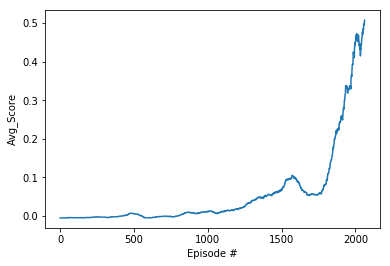

In [18]:
import matplotlib.pyplot as plt
%matplotlib inline


# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(avg_scores)), avg_scores)
plt.ylabel('Avg_Score')
plt.xlabel('Episode #')
plt.show()